## Henon Heiles: Non-Reversible SympNets

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb
from matplotlib import rc

### Import Training Dataset

In [20]:
file = open("x_train_HH_E01667.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

Ty = []
Tydot = []

read_y = open("x_train_HH_E01667.txt", "r")
read_ydot = open("y_train_HH_E01667.txt", "r")


for i in range(line_count):
    Ty.append(float(read_y.readline()))
    Tydot.append(float(read_ydot.readline()))

read_y.close()
read_ydot.close()

print("Number of points: ", len(Ty))

Number of points:  146719


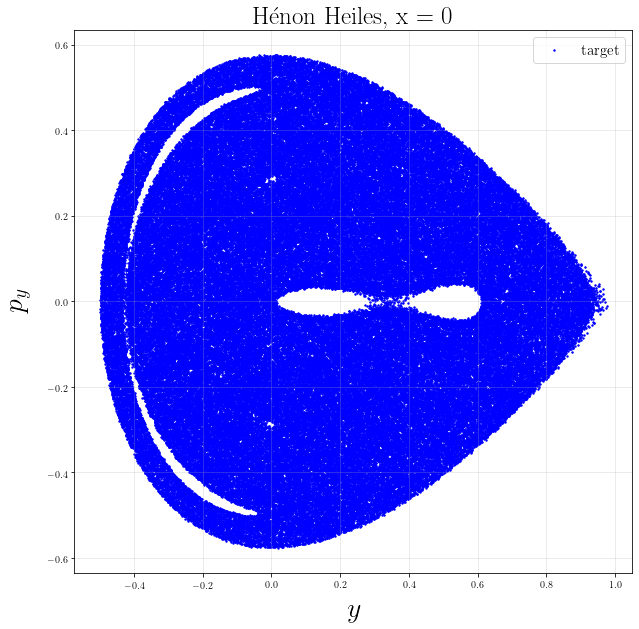

In [21]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'H\'enon Heiles, x = 0', fontsize = 25)
plt.scatter(Ty,Tydot, color = 'b', label = 'target', linewidth = 1, s=2)
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 15, loc = 'upper right')
plt.show()

### Training Dataset

In [22]:
X_train = [np.array([Ty[i],Tydot[i]]) for i in range(len(Ty)-1)]
Y_train = [np.array([Ty[i],Tydot[i]]) for i in range(1,len(Ty))]

In [23]:
# TRAINING SET

x_train = np.array(X_train)
x_train = x_train.astype(np.float32)

y_train = np.array(Y_train)
y_train = y_train.astype(np.float32)


x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(10000)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(10000)

train_dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

----------------------------------------------------
----------------------------------------------------
----------------------------------------------------

### Custom Layers

In [24]:
class linear_module_up(layers.Layer):
    
    def __init__(self, bias):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )
    
        if bias==1:
            self.b = self.add_weight(
            name='b',
            shape=(2,),
            initializer = 'random_normal',
            trainable = True
            )
            
        else:
            self.b = tf.constant([0., 0.])

    def call(self, x):
        
        L = tf.concat([[[1., self.w[0]]],[[0., 1.]]], 0)
        return tf.linalg.matvec(L, x) + self.b


class linear_module_low(layers.Layer):
    
    def __init__(self, bias):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )

        if bias==1:
            self.b = self.add_weight(
            name='b',
            shape=(2,),
            initializer = 'random_normal',
            trainable = True
            )
            
        else:
            self.b = tf.constant([0., 0.])

    def call(self, x):
        
        L = tf.concat([[[1., 0.]],[[self.w[0], 1.]]], 0)
        return tf.linalg.matvec(L,x) + self.b


    

class activation_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):        
        t = tf.concat([[[0., self.w[0]]], [[0.,0.]]], 0)
        return x + tf.linalg.matvec(t, tf.math.tanh(x))

class activation_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):
        t = tf.concat([[[0., 0.]], [[self.w[0], 0.]]], 0)        
        return x + tf.linalg.matvec(t, tf.math.tanh(x))

### SympNet

In [25]:
class SympNet(keras.Model):
    
    def __init__(self, N_layers, N_sub):
        
        super().__init__()
        
        
        self.Modules = []
        
        for i in range(N_layers):
            
            if i%2==0:
                self.Modules.append(activation_module_up())
                
            else:
                self.Modules.append(activation_module_low())
                
            for j in range(N_sub):
                
                if j==(N_sub-1):
                    bias = 1
                else:
                    bias = 0
                
                if j%2==0:
                    self.Modules.append(linear_module_up(bias))

                else:
                    self.Modules.append(linear_module_low(bias))
        
        

    def call(self, input_tensor):
        
        boom = self.Modules[0](input_tensor)
        
        for i in range(1,len(self.Modules)):
            boom = self.Modules[i](boom)
        
        #for i in range(1, len(self.Modules)):
        #    boom = self.Modules[-i](boom)
        
        #boom = self.Modules[0](boom)
    
        return boom

### Training

In [33]:
model = SympNet(25, 5)

In [34]:
# DECAYING LEARNING RATE

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [35]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.01), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [36]:
#wandb.init()
start_time = time.time()
history = model.fit(train_dataset, epochs = 1000, validation_data=val_dataset, callbacks=[callback], verbose=1)
print("running time : %s seconds" % (time.time() - start_time))

Epoch 1/1000
14/14 [==============================] - 5s 358ms/step - loss: 0.2055 - accuracy: 0.5477 - val_loss: 0.1276 - val_accuracy: 0.7506
Epoch 2/1000
14/14 [==============================] - 4s 259ms/step - loss: 0.1248 - accuracy: 0.7049 - val_loss: 0.1221 - val_accuracy: 0.7127
Epoch 3/1000
14/14 [==============================] - 4s 265ms/step - loss: 0.1064 - accuracy: 0.7285 - val_loss: 0.1067 - val_accuracy: 0.7876
Epoch 4/1000
14/14 [==============================] - 4s 271ms/step - loss: 0.0981 - accuracy: 0.7672 - val_loss: 0.0972 - val_accuracy: 0.7718
Epoch 5/1000
14/14 [==============================] - 4s 271ms/step - loss: 0.0940 - accuracy: 0.7576 - val_loss: 0.0982 - val_accuracy: 0.7682
Epoch 6/1000
14/14 [==============================] - 4s 273ms/step - loss: 0.0925 - accuracy: 0.7706 - val_loss: 0.0951 - val_accuracy: 0.7711
Epoch 7/1000
14/14 [==============================] - 4s 289ms/step - loss: 0.0906 - accuracy: 0.7710 - val_loss: 0.0928 - val_accuracy:

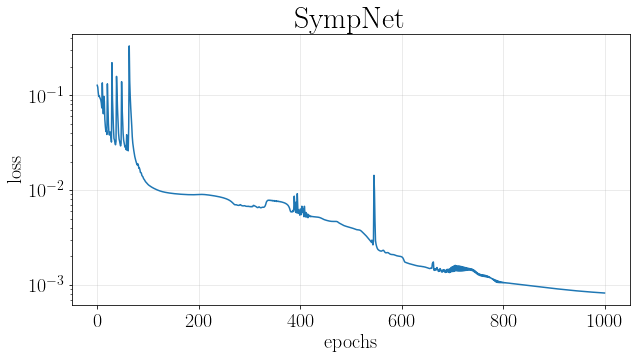

In [39]:
plt.figure(figsize = (10,5))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(history.history["val_loss"])
plt.title("SympNet", fontsize=30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_SympNet_E01667")

## Tests

In [ ]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 30)

x = model(tf.constant([[Ty[0], Tydot[0]]]))
xx = [x[0][0].numpy()]
yy = [x[0][1].numpy()]


for i in range(2):
    x = model(x)
    xx.append(x[0][0].numpy())
    yy.append(x[0][1].numpy())

plt.plot(xx, yy, color='r')

plt.scatter(xx[-1], yy[-1], label=r'$\mathcal{T}^{2}(x,y)$', marker = 'o', color='r', s=35)
plt.scatter(xx[-1], -yy[-1], label=r'$R\mathcal{T}^{2}(x,y)$', marker = 'o', color='b', s=35)


x = model(tf.constant([[xx[-1], -yy[-1]]]))
xx = [xx[-1]]
yy = [-yy[-1]]
xx.append(x[0][0].numpy())
yy.append(x[0][1].numpy())

for i in range(2):
    x = model(x)
    xx.append(x[0][0].numpy())
    yy.append(x[0][1].numpy())

plt.plot(xx,yy, color='b')
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25, loc = 'upper left')
plt.savefig("non_reversible_E01667")
plt.show()

In [42]:
test = model(model(x_train))

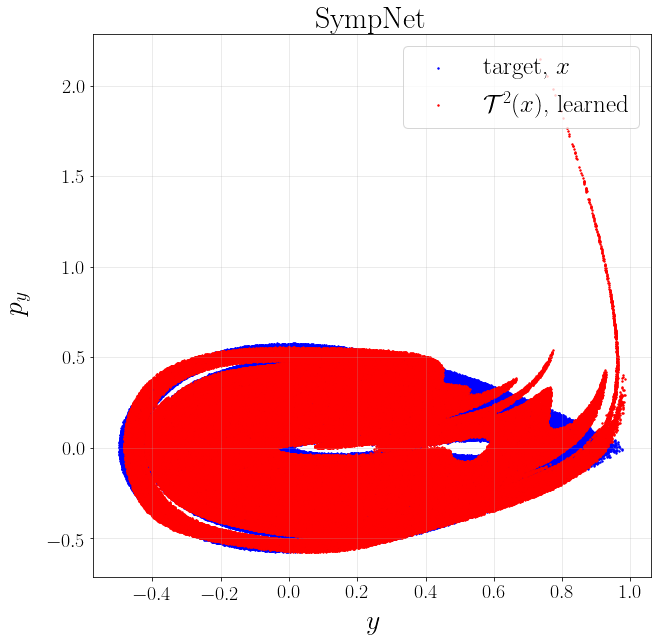

In [43]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 30)
plt.scatter(Ty,Tydot, color = "b", label = r'target, $x$', linewidth = 1, s=2)
plt.scatter([test[i][0].numpy() for i in range(len(x_train))], [test[i][1].numpy() for i in range(len(x_train))], color = "r", label = r'$\mathcal{T}^{2}(x)$, learned', linewidth = 1, s=2)
plt.xlabel(r'$y$', fontsize=28, labelpad=8)
plt.ylabel(r'$p_{y}$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25, loc = 'upper right')
#plt.savefig("Iterations_SympNet_E01667")
plt.show()